---
## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle
import numpy as np
import tensorflow as tf
import random
import csv
from sklearn.utils import shuffle
from tensorflow.contrib.layers import flatten
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# TODO: Fill this in based on where you saved the training and testing data

training_file = 'train.p'
validation_file = 'valid.p'
testing_file = 'test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

In [3]:
print(len(y_train))
print(len(y_valid))
print(len(y_test))

print(X_test.shape)
print(test['labels'])

34799
4410
12630
(12630, 32, 32, 3)
[16  1 38 ...,  6  7 10]


---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [4]:
# Number of training examples
n_train = len(y_train)

# Number of testing examples.
n_test = len(y_test)

# What's the shape of an traffic sign image?
image_shape = X_train.shape[1:4]

# How many unique classes/labels there are in the dataset.
n_classes = np.max(y_train) - np.min(y_train) + 1

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


In [5]:
def show_dataset_summary(pickle_dict):
    X, y = pickle_dict['features'], pickle_dict['labels']
    n_classes = np.max(y_train) - np.min(y_train) + 1
    n_data_of_classes = np.zeros((n_classes,))
    for i in range(n_classes):
        n_data_of_classes[i] = len(y[y == i])
        
    classes_num = [i for i in range(n_classes)]
    
    plt.figure()
    plt.bar(classes_num, n_data_of_classes, align="center", alpha=.5 )
    plt.xlabel('classes')
    plt.ylabel('#')
    plt.xlim([0-.5, classes_num[-1]+.5])
    plt.show()

In [6]:
def plot_test_images(images, nc = 15, nr = 4):
    ct = 0
    fig = plt.figure(figsize=(nc, nr))
    gs = gridspec.GridSpec(nr, nc)
    gs.update(wspace=0.0, hspace=0.0)
    for i in range(nr * nc):
        ax = fig.add_subplot(gs[ct])
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(images[ct,:,:,:])
        ct += 1

    return fig

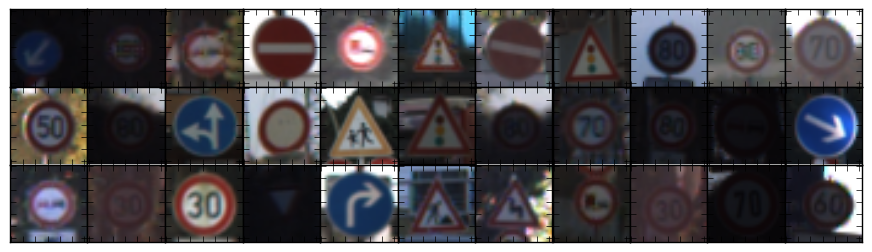

In [7]:
ind_ = np.random.randint(n_train, size=33)
fig = plot_test_images(X_train[ind_, :, :, :], nc=11, nr=3)
plt.savefig('./images/data_example.png')

# Image Augmentation
Dataset에서 각 Class의 수를 맞추기 위해 이미지의 수를 늘린다. 이미지의 수를 늘리기 위해 random하게  crop하고, 이미지의 brightness를 조절한다. 
* 근데 이거 만드는데 거의 2시간 걸림 더 빠르게 돌아갈 수 있도록 수정할 필요가 있음
* batch를 이용하여 I/O의 횟수를 줄인다든가..

In [8]:
from PIL import Image
from PIL import ImageEnhance

In [9]:
# Print iterations progress (http://stackoverflow.com/questions/3173320/text-progress-bar-in-the-console)
def printProgressBar (iteration, total, prefix = '', suffix = '', decimals = 1, length = 100, fill = '█'):
    """
    Call in a loop to create terminal progress bar
    @params:
        iteration   - Required  : current iteration (Int)
        total       - Required  : total iterations (Int)
        prefix      - Optional  : prefix string (Str)
        suffix      - Optional  : suffix string (Str)
        decimals    - Optional  : positive number of decimals in percent complete (Int)
        length      - Optional  : character length of bar (Int)
        fill        - Optional  : bar fill character (Str)
    """
    percent = ("{0:." + str(decimals) + "f}").format(100 * (iteration / float(total)))
    filledLength = int(length * iteration // total)
    bar = fill * filledLength + '-' * (length - filledLength)
    print('\r%s |%s| %s%% %s' % (prefix, bar, percent, suffix), end = '\r')
    # Print New Line on Complete
    if iteration == total: 
        print()

In [10]:
generate_distorted_images = False

In [11]:
if generate_distorted_images == True:
    # set progressbar
    N_rand_total = np.sum(np.floor(3000/n_data_of_classes) * n_data_of_classes)
    N_rand_total = N_rand_total.astype(int)
    N_now = 0
    
    printProgressBar(N_now, N_rand_total, prefix = 'Progress:', suffix = 'Complete', length = 50)
    
    # initialize augmented (X,y)
    X_train_augmented = X_train
    y_train_augmented = y_train

    for i in range(X_train.shape[0]):
        # If you have less than 3000 data, you increase the number of data by random cropping.
        if n_data_of_classes[y_train[i]] <= 3000: 
            N_rand = np.floor(3000/n_data_of_classes[y_train[i]])
            N_rand = N_rand.astype(int)

        for j in range(N_rand):
            
            N_now += 1
            
            # load training images
            X_train_PIL = Image.fromarray(X_train[i,:,:,:])
            
            # set width(=height) and start points for random cropping
            rw = np.floor(random.random()*12 + 18) # random width (18~30)
            rw = int(rw)
            rs = np.floor((32 - rw) * random.random()) # random crop start point
            rs = int(rs)

            # randomly crop and reshape to (32,32,3)
            randomly_cropped_image = X_train_PIL.crop((rs,rs,rs+rw,rs+rw))
            distorted_image = randomly_cropped_image.resize((32,32), Image.ANTIALIAS)

            # randomly adjust brightness
            enhancer = ImageEnhance.Brightness(distorted_image)
            distorted_image_ = enhancer.enhance(random.random())

            # convert image to uint8 array
            distorted_image_ = np.array(distorted_image_, dtype=np.uint8)

            # append distorted image on X_train
            distorted_image_ = distorted_image_[np.newaxis,:] # (expand dimension from (32,32,3) to (1,32,32,3))
            X_train_augmented = np.append(X_train_augmented, distorted_image_, axis=0)
            y_train_augmented = np.append(y_train_augmented, [y_train[i]], axis=0)
            
            printProgressBar(N_now, N_rand_total, prefix = 'Progress:', suffix = 'Complete', length = 50)

    print("augmented training images are generated.")
    print("%d -> %d" %(X_train.shape[0], X_train_augmented.shape[0]))

In [12]:
if generate_distorted_images == True:
    # make dictionary 
    train_augmented = {'features': X_train_augmented, 'labels': y_train_augmented}

    # save augmented training dataset
    adata_name = "train_aug.p"
    with open(adata_name, "wb") as f:
        pickle.dump(train_augmented, f)

### Augmented Dataset Summary
Load augmented dataset and show summary

In [13]:
with open("train_aug.p", mode="rb") as f:
    train = pickle.load(f)

X_train, y_train = train['features'], train['labels']

number of data for each class (augmented dataset):


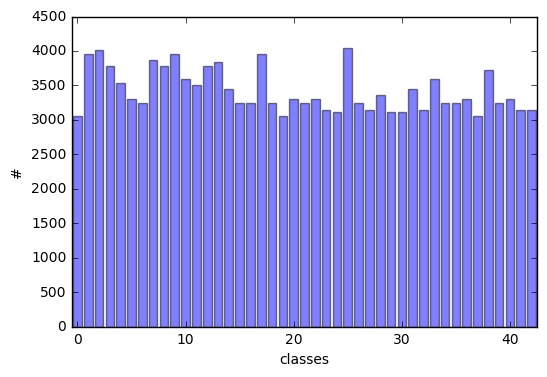

In [14]:
print('number of data for each class (augmented dataset):')
show_dataset_summary(train)

In [15]:
# normalize images into [-0.5, 0.5]
# after normalization, images become float64 type.
def normalize_images(X_):
    return X_ / 255 - 0.5

X_train_ = normalize_images(X_train)
print('training set is normalized')

X_valid_ = normalize_images(X_valid)
print('Validation set is normalized')

X_test_ = normalize_images(X_test)
print('Test set is normalized')

training set is normalized
Validation set is normalized
Test set is normalized


### Model Architecture

In [16]:
# tensorflow graph input
x = tf.placeholder(tf.float64, (None, 32, 32, 3))
x = tf.cast(x, tf.float32)
y = tf.placeholder(tf.uint8, (None))
one_hot_y = tf.one_hot(y, n_classes)
keep_prob = tf.placeholder(tf.float32)

In [17]:
# parameters
rate = 0.001
EPOCHS = 20
BATCH_SIZE = 4096
display_step = 2
save_step = 5

# do train?
do_train = 1
epoch_to_restore = 590

# select device to be used
device_type = "/gpu:0"

In [18]:
### LeNet with batch normalization

def LeNet_he(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1

    # Layer 1: Convolutional. Input = 32x32x3. Output = 28x28x32.
    conv1_w = tf.Variable(tf.truncated_normal(shape=(5,5,3,32), mean=mu, stddev=np.sqrt(2/(5*5*3))))
    conv1_b = tf.Variable(tf.zeros(32))
    conv1 = tf.nn.conv2d(x, conv1_w, strides=[1,1,1,1], padding='VALID') + conv1_b

    # batch normalization
    mean_, var_ = tf.nn.moments(conv1, [0,1,2])
    conv1 = tf.nn.batch_normalization(conv1, mean_, var_, 0, 1, 0.0001)


    # Activation.
    conv1 = tf.nn.relu(conv1)

    # Pooling. Input = 28x28x32. Output = 14x14x32.
    conv1 = tf.nn.max_pool(conv1, ksize=[1,2,2,1],strides=[1,2,2,1], padding='VALID')

    # Layer 2: Convolutional. Output = 10x10x64.
    conv2_w = tf.Variable(tf.truncated_normal(shape=(5,5,32,64), mean=mu, stddev=np.sqrt(2/(5*5*32))))
    conv2_b = tf.Variable(tf.zeros(64))
    conv2 = tf.nn.conv2d(conv1, conv2_w, strides=[1,1,1,1], padding='VALID') + conv2_b 

    # batch normalization
    mean_, var_ = tf.nn.moments(conv2, [0,1,2])
    conv2 = tf.nn.batch_normalization(conv2, mean_, var_, 0, 1, 0.0001)


    # Activation.
    conv2 = tf.nn.relu(conv2)

    # Pooling. Input = 10x10x64. Output = 5x5x64.
    conv2 = tf.nn.max_pool(conv2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='VALID')

    # Flatten. Input = 5x5x64. Output = 1600.
    fc0 = flatten(conv2)

    # Layer 3: Fully Connected. Input = 1600. Output = 120.
    fc1_w = tf.Variable(tf.truncated_normal(shape=(1600,120), mean=mu, stddev=np.sqrt(2/(1600))))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1 = tf.matmul(fc0, fc1_w) + fc1_b

    # batch normalization
    mean_, var_ = tf.nn.moments(fc1, axes=[0])
    fc1 = tf.nn.batch_normalization(fc1, mean_, var_, 0, 1, 0.0001)

    # Activation.
    fc1 = tf.nn.relu(fc1)

    # Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_w = tf.Variable(tf.truncated_normal(shape=(120,84), mean=mu, stddev=np.sqrt(2/120)))
    fc2_b = tf.Variable(tf.zeros(84))
    fc2 = tf.matmul(fc1, fc2_w) + fc2_b

    # batch normalization
    mean_, var_ = tf.nn.moments(fc2, axes=[0])
    fc2 = tf.nn.batch_normalization(fc2, mean_, var_, 0, 1, 0.0001)

    # Activation.
    fc2 = tf.nn.relu(fc2)

    # Layer 5: Fully Connected. Input = 84. Output = 43.
    fc3_w = tf.Variable(tf.truncated_normal(shape=(84,43), mean=mu, stddev=np.sqrt(2/84)))
    fc3_b = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_w) + fc3_b

    return logits

print('LeNet w/ He initialziation is ready')

LeNet w/ He initialziation is ready


In [19]:
with tf.device(device_type):
#     logits = LeNet(x, keep_prob)
    logits = LeNet_he(x)
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=one_hot_y)
    
    loss_operation = tf.reduce_mean(cross_entropy)

    optimizer = tf.train.AdamOptimizer(learning_rate = rate)
    training_operation = optimizer.minimize(loss_operation)

    correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
    accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [20]:
saver = tf.train.Saver()

## Optimize Network


In [21]:
config = tf.ConfigProto(allow_soft_placement=True)
config.gpu_options.allow_growth = True

In [44]:
with tf.Session(config=config) as sess, open('LeNet_He_BatchNorm.csv', 'w') as csvfile:
    # prepare loging file
    fieldnames = ['epoch', 'loss', 'train_acc', 'test_acc']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()
    
    # training
    if do_train == 1:
        # initialize TensorFlow variables
        sess.run(tf.global_variables_initializer())
        
        num_examples = len(X_train_)

        print("Training...")
        print()
        
        # epoch
        for epoch in range(EPOCHS):
            avg_loss = 0.
            total_batch = int(num_examples/BATCH_SIZE)

            X_train_, y_train = shuffle(X_train_, y_train)
            for offset in range(0, num_examples, BATCH_SIZE):
                end = offset + BATCH_SIZE
                batch_x, batch_y = X_train_[offset:end], y_train[offset:end]
                sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
                avg_loss += sess.run(loss_operation, feed_dict={x: batch_x, y: batch_y})/total_batch

            if epoch % display_step == 0:
                train_acc = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
                valid_acc = sess.run(accuracy_operation, feed_dict={x: X_valid_, y: y_valid})
                
                print("Epoch: %03d/%03d, loss: %.9f, train acc: %.3f, valid acc: %.3f" 
                      % (epoch + 1, EPOCHS, avg_loss, train_acc, valid_acc))

            if epoch % save_step == 0:
                saver.save(sess, "nets/traffic_sign_lenet-" + str(epoch))
            
            # log 
            writer.writerow({'epoch': epoch + 1, 'loss': avg_loss, 'train_acc': train_acc, 'test_acc': valid_acc})
                
        test_acc = sess.run(accuracy_operation, feed_dict={x: X_test_, y:y_test})        
        print("Test accuracy: %.3f" % (test_acc))
    
    if do_train == 0:
#         epoch = epoch_to_restore
        saver.restore(sess, tf.train.latest_checkpoint('nets/'))
        print("Model restored.")
        
        # calculate training accuracy
        batch_size_for_cal = 10000
        n_train_right = 0
        offset = 0
        tstep = np.floor(X_train_.shape[0]/10000)
        for t in range(tstep.astype(int)):            
            if X_train_.shape[0] - (batch_size_for_cal + offset) < 0:
                batch_size_for_cal = X_train_.shape[0] - offset
            n_train_right += sess.run(accuracy_operation, 
                                     feed_dict={x: X_train_[offset:offset+batch_size_for_cal],
                                                y: y_train[offset:offset+batch_size_for_cal]}) * batch_size_for_cal
        
        train_acc = n_train_right/X_train_.shape[0]
        
        # validation and test accuracy
        valid_acc = sess.run(accuracy_operation, feed_dict={x: X_valid_, y: y_valid})
        test_acc = sess.run(accuracy_operation, feed_dict={x: X_test_, y:y_test})
        print("Train accuracy: %.3f" % (train_acc))
        print("Validation accuracy: %.3f" % (valid_acc))
        print("Test accuracy: %.3f" % (test_acc))
        
    valid_writer.close()


Training...

Epoch: 000/020, loss: 2.694441063, train acc: 0.579, valid acc: 0.605
Epoch: 001/020, loss: 1.510054990, train acc: 0.770, valid acc: 0.761
Epoch: 002/020, loss: 0.986708854, train acc: 0.854, valid acc: 0.812
Epoch: 003/020, loss: 0.728598402, train acc: 0.885, valid acc: 0.846
Epoch: 004/020, loss: 0.585963874, train acc: 0.906, valid acc: 0.864
Epoch: 005/020, loss: 0.488606003, train acc: 0.916, valid acc: 0.860
Epoch: 006/020, loss: 0.428171385, train acc: 0.932, valid acc: 0.859
Epoch: 007/020, loss: 0.378213395, train acc: 0.941, valid acc: 0.873
Epoch: 008/020, loss: 0.338423643, train acc: 0.939, valid acc: 0.873
Epoch: 009/020, loss: 0.311944977, train acc: 0.947, valid acc: 0.870
Epoch: 010/020, loss: 0.287324123, train acc: 0.951, valid acc: 0.874
Epoch: 011/020, loss: 0.270878194, train acc: 0.954, valid acc: 0.880
Epoch: 012/020, loss: 0.251981788, train acc: 0.948, valid acc: 0.876
Epoch: 013/020, loss: 0.236124060, train acc: 0.954, valid acc: 0.885
Epoch: 

## show the result

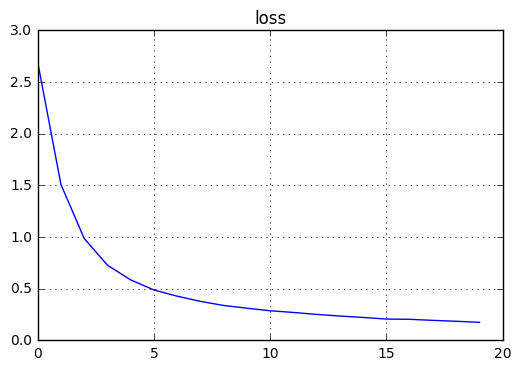

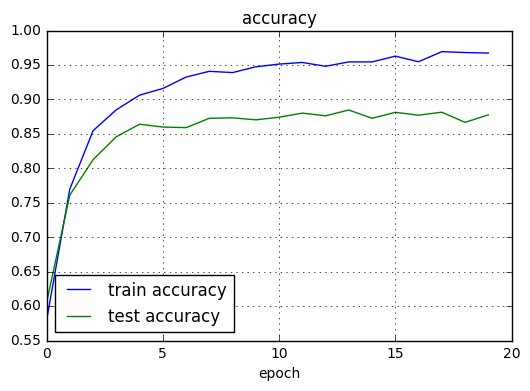

In [52]:
import matplotlib.pyplot as plt

with open('LeNet_He_BatchNorm.csv', 'r') as csvfile:
    data = []
    reader = csv.reader(csvfile)
    for row in reader:
        data.append(row)
#         print(', '.join(row))
        
data = np.array(data)

plt.figure()
plt.plot(data[1:,0], data[1:,1])
plt.title('loss')
plt.grid()
plt.show()

plt.figure()
plt.plot(data[1:,0], data[1:,2], label='train accuracy')
plt.plot(data[1:,0], data[1:,3], label='test accuracy')
plt.title('accuracy')
plt.xlabel('epoch')
plt.legend(loc='best')
plt.grid()
plt.show()

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

Five pictures of German traffic signs from the web:


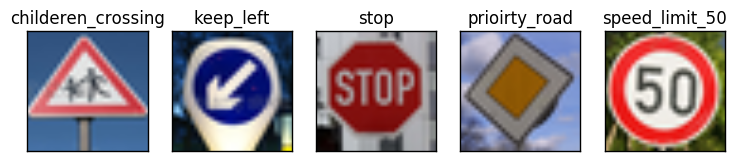

img_set size: (5, 32, 32, 3)


In [30]:
### Load the images and plot them here.
# Import images from folder
import os
from PIL import Image

img_set = np.ones(shape=(5,32,32,3))
n_test_img = 0
target_img_file_names = []

print('Five pictures of German traffic signs from the web:')

fig = plt.figure(figsize=(9,3))

for img_file in os.listdir("./german_traffic_signs"): 
    if img_file.endswith(".png"):
        # save file name
        target_img_file_names.append(img_file)
        
        # load images and resize it to (32,32,3)
        img = Image.open('./german_traffic_signs/' + img_file).convert('RGB') # load image into RGB
        img = img.resize((32,32), Image.ANTIALIAS) # resizes image in-place
        
        # append image as (N, 32, 32, 3) 
        img_set[n_test_img,:,:,:] = np.array(img, dtype=np.float32)/1.0
        n_test_img += 1
        
        # Print the names and pictures of the target images
        ax_ = fig.add_subplot(1, 5, n_test_img)
        ax_.imshow(img, cmap="gray")
        ax_.set_title(img_file[5:-4])
        ax_.set_xticks([])
        ax_.set_yticks([])
# plt.savefig('five_test_images.png')
plt.show()
        
# print appended image shape
print('img_set size: ' + str(img_set.shape))

### Predict the Sign Type for Each Image

In [31]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.
X_img_test = normalize_images(img_set)

with tf.Session(config=config) as sess:
    epoch = epoch_to_restore
    saver.restore(sess, tf.train.latest_checkpoint('nets/'))
    predict_type = sess.run(tf.argmax(logits, 1), feed_dict={x: X_img_test})
    print(predict_type)

[28 40 14 12  2]


In [32]:
print(predict_type.dtype)
print(predict_type[0])
print(predict_type[1])

int64
28
40


In [33]:
with open('signnames.csv') as csvfile:
    reader = csv.DictReader(csvfile)
    SignNames = []
    for row in reader:
        csv_ = row['SignName']
        SignNames.append(csv_)

In [34]:
for predict_ind in range(len(predict_type)):
    print('File name: %-025s Predicted name: %s'%(target_img_file_names[predict_ind][5:-4] , SignNames[predict_type[predict_ind]]))

File name: childeren_crossing        Predicted name: Children crossing
File name: keep_left                 Predicted name: Roundabout mandatory
File name: stop                      Predicted name: Stop
File name: prioirty_road             Predicted name: Priority road
File name: speed_limit_50            Predicted name: Speed limit (50km/h)


### Analyze Performance

In [45]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.
y_new_true = [28, 39, 14, 12, 2] # children crossing (28), keep left (39), stop (14), prioirty road (12), speed limit (2) 

with tf.Session(config=config) as sess:
    saver.restore(sess, tf.train.latest_checkpoint('nets/'))
    test_img_acc = sess.run(accuracy_operation, feed_dict={x: X_img_test, y: y_new_true})
    y_new_pred = sess.run(tf.argmax(logits, 1), feed_dict={x: X_img_test})
    print('The accuracy for these 5 new images: %.2f' % (test_img_acc))

The accuracy for these 5 new images: 0.80


In [46]:
### Create confusion matrix using test set
## test set prediction
with tf.Session(config=config) as sess:
    saver.restore(sess, tf.train.latest_checkpoint('nets/'))
    y_test_pred = sess.run(tf.argmax(logits, 1), feed_dict={x: X_test_})


In [47]:
## configure confussion matrix
from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.title(title)
    
    tick_marks = np.arange(len(classes))
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
        
    # write the values of confusion matrix
    cm_font ={'size': '7'}
    tick_font = {'size': '8'}
    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if cm[i,j] >= 0.02:
            plt.text(j, i, '{:.2f}'.format(cm[i, j])[1:],
                     horizontalalignment="center",
                     verticalalignment="center",
                     color="white" if cm[i, j] > thresh else "black",
                     **cm_font)
        
    
    plt.xticks(tick_marks, classes, **tick_font)
    plt.yticks(tick_marks, classes, **tick_font)
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.tight_layout()
    
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    plt.colorbar()
    plt.grid()

Normalized confusion matrix


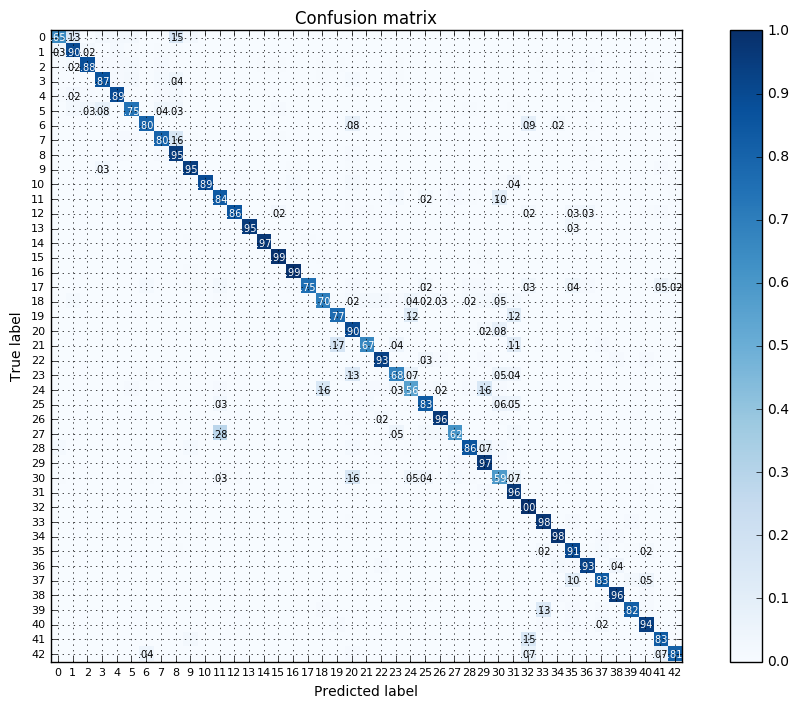

In [48]:
# compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_test_pred)
np.set_printoptions(precision=2)
classes = [str(i) for i in range(len(SignNames))]

# Plot non-normalized confusion matrix
plt.figure(figsize=(10,7))
plot_confusion_matrix(cnf_matrix, classes=classes, title='Confusion matrix', normalize=True)
# plt.savefig('confusion_matrix.png')
plt.show()


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

In [ ]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.
with tf.Session(config=config) as sess:
    saver.restore(sess, tf.train.latest_checkpoint('nets/'))
    y_test_pred_top5 = sess.run(tf.nn.top_k(tf.nn.softmax(logits), k=10), feed_dict={x: X_img_test, keep_prob: 1.0})

In [ ]:
for i in range(len(y_new_true)):
#     print(y_new_true[i])
    plt.bar(y_test_pred_top5.indices[i,:], y_test_pred_top5.values[i,:], align="center", alpha=.5 )
    print(y_test_pred_top5.indices[i,:])
    print(y_test_pred_top5.values[i,:])
    plt.title('True = %d, Estimated = %d' %(y_new_true[i], y_new_pred[i]))
    plt.ylim([0, 1])
    plt.xlabel('Classes')
    plt.ylabel('Probabilities')
    plt.savefig('top_prob_' + str(i))
    plt.show()


In [ ]:
print('Test Images for class 28 and 29')
fig = plot_test_images(X_test[y_test == 28, :, :, :], 6, 3)
plt.savefig('test_28s.png')
plt.show()

fig_ = plot_test_images(X_test[y_test == 29, :, :, :], 6, 3)
plt.savefig('test_29s.png')
plt.show()

---

## Step 4: Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [ ]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it maybe having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")